In [22]:
jogos = pd.read_csv('jogos_todos_formatados.csv')
jogos.visitante.unique()

array(['Cruzeiro', 'Flamengo', 'Ceará', 'Sport Recife',
       'Atlético Mineiro', 'Fluminense', 'Bahia', 'Chapecoense',
       'Botafogo', 'Parana', 'America', 'Corinthians', 'Internacional',
       'Vasco da Gama', 'São Paulo', 'Vitória', 'Athletico Paranaense',
       'Palmeiras', 'Santos Fc', 'Grêmio', 'Avaí', 'Csa', 'Fortaleza',
       'Goiás', 'Red Bull Bragantino', 'Atlético Goianiense', 'Coritiba',
       'Cuiabá', 'Juventude', 'Criciúma'], dtype=object)

In [24]:
import pandas as pd
import os

# === CONFIGURAÇÕES ===
ARQUIVO_JOGOS = 'jogos_todos_formatados.csv'
ARQUIVO_ELO = 'elo_historico.csv'
ELO_INICIAL = 1000
K = 30  # fator de ajuste

# === FUNÇÃO DE ATUALIZAÇÃO DE ELO ===
def atualizar_elo(elo_mandante, elo_visitante, gols_mandante, gols_visitante, k=K):
    resultado_mandante = 1 if gols_mandante > gols_visitante else 0.5 if gols_mandante == gols_visitante else 0
    resultado_visitante = 1 - resultado_mandante

    expectativa_mandante = 1 / (1 + 10 ** ((elo_visitante - elo_mandante) / 400))
    expectativa_visitante = 1 - expectativa_mandante

    novo_elo_mandante = elo_mandante + k * (resultado_mandante - expectativa_mandante)
    novo_elo_visitante = elo_visitante + k * (resultado_visitante - expectativa_visitante)

    return novo_elo_mandante, novo_elo_visitante

# === FUNÇÃO PRINCIPAL ===
def calcular_elo_por_data():
    # Lê o arquivo de jogos
    df = pd.read_csv(ARQUIVO_JOGOS)
    df['data'] = pd.to_datetime(df['data'], errors='coerce')
    df = df.sort_values(by=['data']).reset_index(drop=True)

    # Carrega histórico existente (se houver)
    if os.path.exists(ARQUIVO_ELO):
        df_historico = pd.read_csv(ARQUIVO_ELO)
        elos = {row['time']: row['elo'] for _, row in df_historico.groupby('time').last().iterrows()}
        print(f"🔁 Histórico existente carregado ({len(elos)} times).")
    else:
        df_historico = pd.DataFrame(columns=['ano', 'rodada', 'data', 'time', 'elo'])
        elos = {}
        print("🆕 Iniciando novo cálculo de Elo.")

    # Processa cada jogo
    for idx, row in df.iterrows():
        ano, rodada = row['ano'], row['rodada']
        mandante, visitante = row['mandante'], row['visitante']
        gols_m, gols_v = row['gol_time_mandante'], row['gol_time_visitante']
        data = row['data']

        # Inicializa times novos
        if mandante not in elos:
            elos[mandante] = ELO_INICIAL
        if visitante not in elos:
            elos[visitante] = ELO_INICIAL

        # Atualiza elos
        novo_elo_m, novo_elo_v = atualizar_elo(elos[mandante], elos[visitante], gols_m, gols_v)
        elos[mandante], elos[visitante] = novo_elo_m, novo_elo_v

        # Adiciona registros
        novos_registros = pd.DataFrame([
            {'ano': ano, 'rodada': rodada, 'data': data, 'time': mandante, 'elo': round(novo_elo_m, 2)},
            {'ano': ano, 'rodada': rodada, 'data': data, 'time': visitante, 'elo': round(novo_elo_v, 2)}
        ])

        # Anexa e salva incrementalmente
        df_historico = pd.concat([df_historico, novos_registros], ignore_index=True)
        df_historico.to_csv(ARQUIVO_ELO, index=False)

        #print(f"✅ Atualizado: {data.date()} | {mandante} x {visitante} ({gols_m}x{gols_v})")

    print(f"\n🏁 Cálculo concluído. Elo histórico salvo em '{ARQUIVO_ELO}' com {len(df_historico)} linhas.")


calcular_elo_por_data()


C:\Users\Alex Moulin\AppData\Local\Temp\ipykernel_15844\2225454952.py:27: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['data'] = pd.to_datetime(df['data'], errors='coerce')
C:\Users\Alex Moulin\AppData\Local\Temp\ipykernel_15844\2225454952.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_historico = pd.concat([df_historico, novos_registros], ignore_index=True)


🆕 Iniciando novo cálculo de Elo.

🏁 Cálculo concluído. Elo histórico salvo em 'elo_historico.csv' com 5320 linhas.


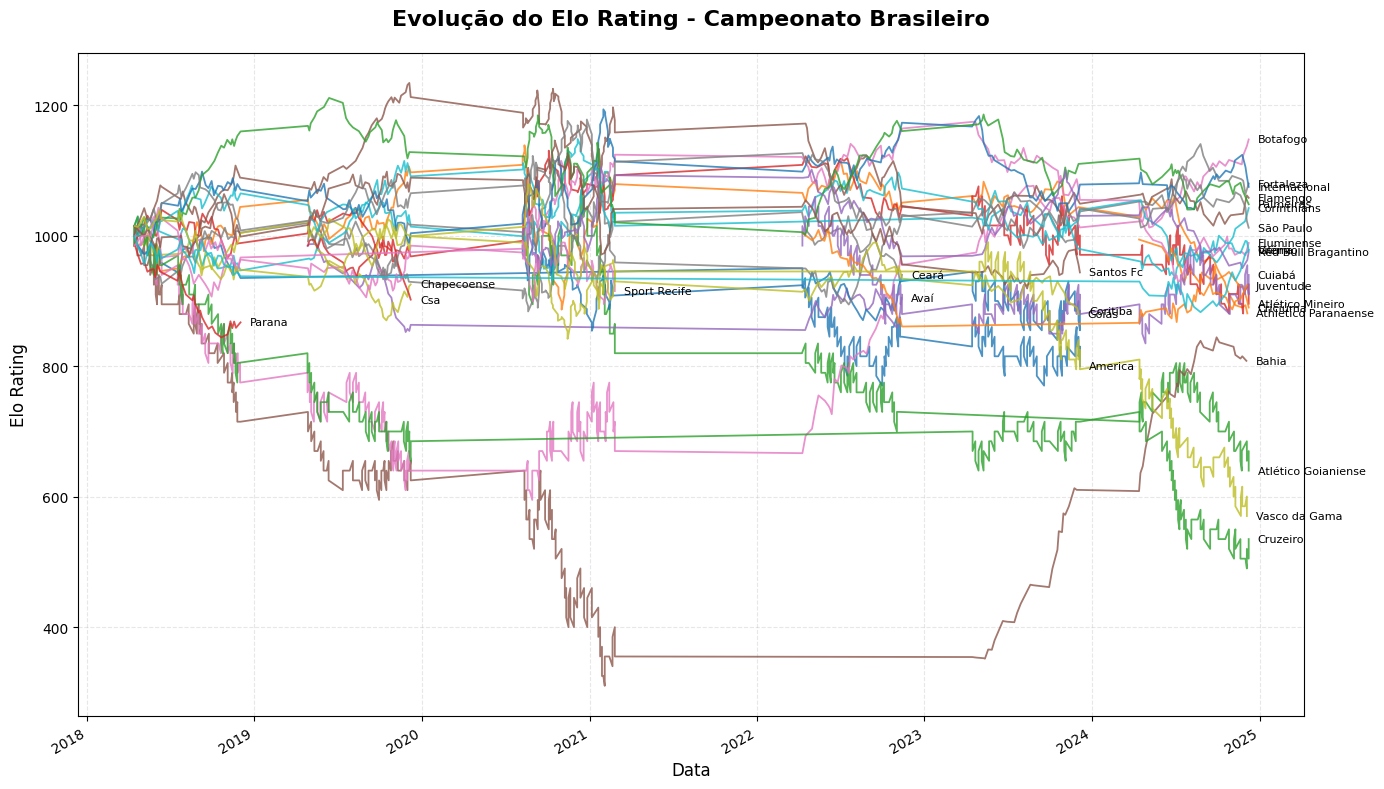

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# === CONFIGURAÇÃO ===
ARQUIVO_ELO = 'elo_historico.csv'

# === LEITURA DOS DADOS ===
df = pd.read_csv(ARQUIVO_ELO)
df['data'] = pd.to_datetime(df['data'], errors='coerce')
df = df.sort_values(by=['data', 'time']).reset_index(drop=True)

# === PLOTAGEM ===
plt.figure(figsize=(14, 8))
ax = plt.gca()

# Determina a posição do último ponto de cada time
ultimos = df.sort_values('data').groupby('time').last().reset_index()

for time in sorted(df['time'].unique()):
    dados = df[df['time'] == time]
    plt.plot(dados['data'], dados['elo'], linewidth=1.3, alpha=0.8)
    
    # Adiciona o nome do time ao final da linha
    ultimo_ponto = dados.iloc[-1]
    ax.text(
        ultimo_ponto['data'] + pd.Timedelta(days=20),  # desloca o nome um pouco à direita
        ultimo_ponto['elo'],
        time,
        fontsize=8,
        color='black',
        va='center'
    )

# === FORMATAÇÃO DO GRÁFICO ===
plt.title('Evolução do Elo Rating - Campeonato Brasileiro', fontsize=16, weight='bold', pad=20)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Elo Rating', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)

# Formatação do eixo X (por ano)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()

# Remove a legenda para evitar poluição
plt.tight_layout()
plt.show()


In [27]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# === CONFIGURAÇÕES ===
ARQUIVO_JOGOS = 'jogos_todos_formatados.csv'
ARQUIVO_ELO = 'elo_historico_ajustado.csv'
ELO_INICIAL = 1000
K = 30  # fator base de ajuste

# === FUNÇÃO DE ATUALIZAÇÃO DE ELO (com ajustes de casa e diferença de gols) ===
def atualizar_elo(elo_mandante, elo_visitante, gols_mandante, gols_visitante, k=K):
    # Resultado esperado (clássico)
    expectativa_mandante = 1 / (1 + 10 ** ((elo_visitante - elo_mandante) / 400))
    expectativa_visitante = 1 - expectativa_mandante

    # Resultado real
    resultado_mandante = 1 if gols_mandante > gols_visitante else 0.5 if gols_mandante == gols_visitante else 0
    resultado_visitante = 1 - resultado_mandante

    # Fator de diferença de gols (mínimo 1)
    diferenca_gols = abs(gols_mandante - gols_visitante)
    fator_diferenca = max(1, diferenca_gols)

    # Incremento básico de Elo
    delta_mandante = k * (resultado_mandante - expectativa_mandante) * fator_diferenca
    delta_visitante = k * (resultado_visitante - expectativa_visitante) * fator_diferenca

    # Ajuste do fator casa:
    #  - Vitória em casa: impacto reduzido (multiplica por 0.9)
    #  - Derrota em casa: impacto ampliado (multiplica por 1.1)
    #  - Empate: sem ajuste adicional
    if resultado_mandante == 1:
        delta_mandante *= 0.9
    elif resultado_mandante == 0:
        delta_mandante *= 1.1

    # Atualiza Elos
    novo_elo_mandante = elo_mandante + delta_mandante
    novo_elo_visitante = elo_visitante + delta_visitante

    return novo_elo_mandante, novo_elo_visitante


# === FUNÇÃO PRINCIPAL ===
def calcular_elo_por_data():
    df = pd.read_csv(ARQUIVO_JOGOS)
    df['data'] = pd.to_datetime(df['data'], errors='coerce')
    df = df.sort_values(by=['data']).reset_index(drop=True)

    elos = {}
    historico = []

    print("🏁 Iniciando cálculo de Elo ajustado...")

    for _, row in df.iterrows():
        ano, rodada, mandante, visitante = row['ano'], row['rodada'], row['mandante'], row['visitante']
        gols_m, gols_v, data = row['gol_time_mandante'], row['gol_time_visitante'], row['data']

        # Inicializa times
        if mandante not in elos:
            elos[mandante] = ELO_INICIAL
        if visitante not in elos:
            elos[visitante] = ELO_INICIAL

        # Atualiza os Elos com os ajustes
        novo_elo_m, novo_elo_v = atualizar_elo(elos[mandante], elos[visitante], gols_m, gols_v)
        elos[mandante], elos[visitante] = novo_elo_m, novo_elo_v

        # Guarda histórico


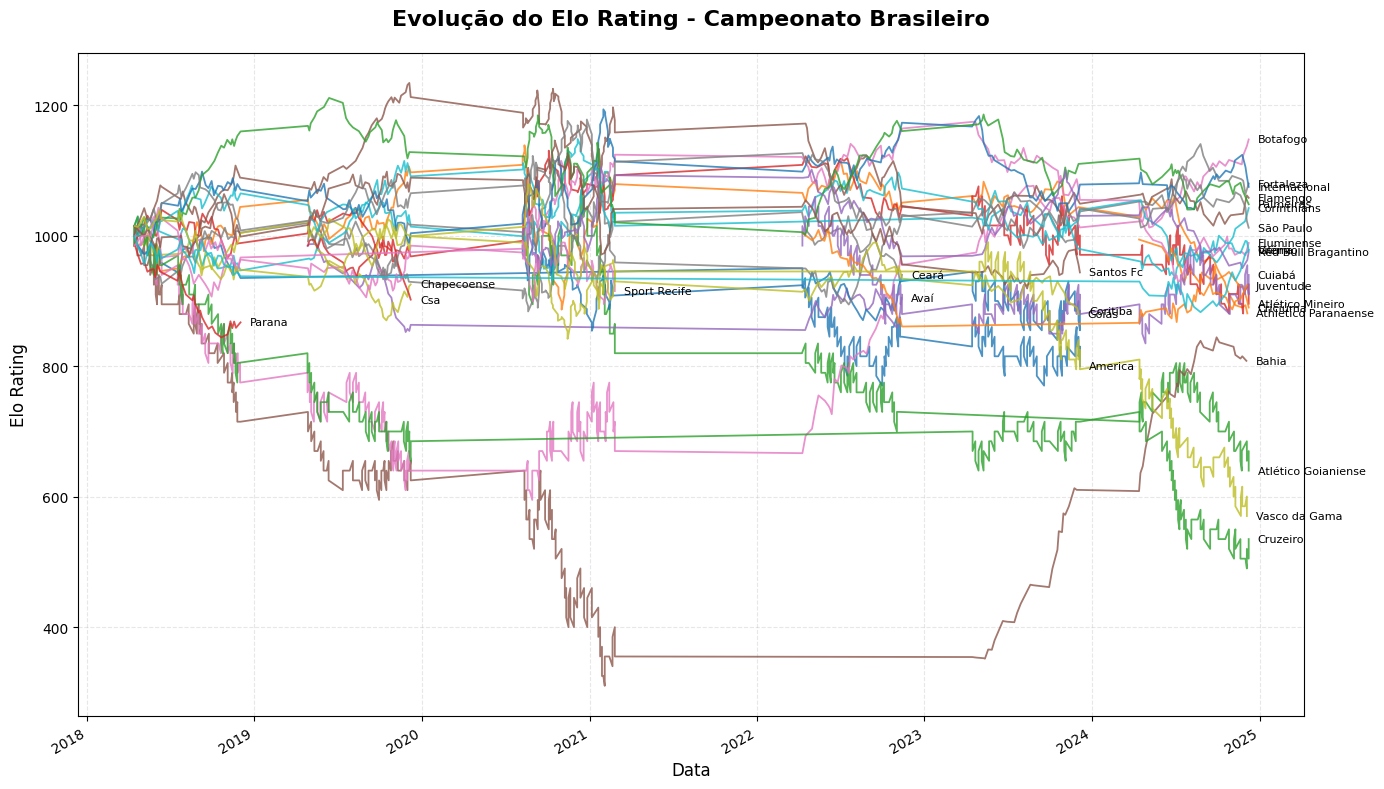

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# === CONFIGURAÇÃO ===
ARQUIVO_ELO = 'elo_historico.csv'

# === LEITURA DOS DADOS ===
df = pd.read_csv(ARQUIVO_ELO)
df['data'] = pd.to_datetime(df['data'], errors='coerce')
df = df.sort_values(by=['data', 'time']).reset_index(drop=True)

# === PLOTAGEM ===
plt.figure(figsize=(14, 8))
ax = plt.gca()

# Determina a posição do último ponto de cada time
ultimos = df.sort_values('data').groupby('time').last().reset_index()

for time in sorted(df['time'].unique()):
    dados = df[df['time'] == time]
    plt.plot(dados['data'], dados['elo'], linewidth=1.3, alpha=0.8)
    
    # Adiciona o nome do time ao final da linha
    ultimo_ponto = dados.iloc[-1]
    ax.text(
        ultimo_ponto['data'] + pd.Timedelta(days=20),  # desloca o nome um pouco à direita
        ultimo_ponto['elo'],
        time,
        fontsize=8,
        color='black',
        va='center'
    )

# === FORMATAÇÃO DO GRÁFICO ===
plt.title('Evolução do Elo Rating - Campeonato Brasileiro', fontsize=16, weight='bold', pad=20)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Elo Rating', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)

# Formatação do eixo X (por ano)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()

# Remove a legenda para evitar poluição
plt.tight_layout()
plt.show()


# 2025

In [32]:
df = pd.read_csv('jogos_2025_formatados.csv')
df

,ano,rodada,gol_time_mandante,gol_time_visitante,mandante,visitante,data,local
0,2025,1,2,1,Cruzeiro Saf,Mirassol,29/03/2025,Mineirão - Belo Horizonte - MG
1,2025,1,2,1,Grêmio,Atlético Mineiro Saf,29/03/2025,Arena do Grêmio - Porto Alegre - RS
2,2025,1,2,0,Fortaleza Ec Saf,Fluminense,29/03/2025,Arena Castelão - Fortaleza - CE
3,2025,1,2,0,Juventude,Vitória,29/03/2025,Alfredo Jaconi - Caxias do Sul - RS
4,2025,1,0,0,São Paulo,Sport Recife,29/03/2025,Morumbi - Sao Paulo - SP
...,...,...,...,...,...,...,...,...
302,2025,31,2,0,Corinthians,Grêmio,02/11/2025,Neo Química Arena - Sao Paulo - SP
303,2025,31,2,0,Ceará,Fluminense,02/11/2025,Arena Castelão - Fortaleza - CE
304,2025,31,0,0,Internacional,Atlético Mineiro Saf,02/11/2025,Beira-Rio - Porto Alegre - RS
305,2025,31,0,2,Juventude,Palmeiras,02/11/2025,Alfredo Jaconi - Caxias do Sul - RS


In [33]:
import pandas as pd
import os

# === CONFIGURAÇÕES ===
ARQUIVO_JOGOS = 'jogos_2025_formatados.csv'
ARQUIVO_ELO = 'elo_2025.csv'
ELO_INICIAL = 1000
K = 30  # fator de ajuste

# === FUNÇÃO DE ATUALIZAÇÃO DE ELO ===
def atualizar_elo(elo_mandante, elo_visitante, gols_mandante, gols_visitante, k=K):
    resultado_mandante = 1 if gols_mandante > gols_visitante else 0.5 if gols_mandante == gols_visitante else 0
    resultado_visitante = 1 - resultado_mandante

    expectativa_mandante = 1 / (1 + 10 ** ((elo_visitante - elo_mandante) / 400))
    expectativa_visitante = 1 - expectativa_mandante

    novo_elo_mandante = elo_mandante + k * (resultado_mandante - expectativa_mandante)
    novo_elo_visitante = elo_visitante + k * (resultado_visitante - expectativa_visitante)

    return novo_elo_mandante, novo_elo_visitante

# === FUNÇÃO PRINCIPAL ===
def calcular_elo_por_data():
    # Lê o arquivo de jogos
    df = pd.read_csv(ARQUIVO_JOGOS)
    df['data'] = pd.to_datetime(df['data'], errors='coerce')
    df = df.sort_values(by=['data']).reset_index(drop=True)

    # Carrega histórico existente (se houver)
    if os.path.exists(ARQUIVO_ELO):
        df_historico = pd.read_csv(ARQUIVO_ELO)
        elos = {row['time']: row['elo'] for _, row in df_historico.groupby('time').last().iterrows()}
        print(f"🔁 Histórico existente carregado ({len(elos)} times).")
    else:
        df_historico = pd.DataFrame(columns=['ano', 'rodada', 'data', 'time', 'elo'])
        elos = {}
        print("🆕 Iniciando novo cálculo de Elo.")

    # Processa cada jogo
    for idx, row in df.iterrows():
        ano, rodada = row['ano'], row['rodada']
        mandante, visitante = row['mandante'], row['visitante']
        gols_m, gols_v = row['gol_time_mandante'], row['gol_time_visitante']
        data = row['data']

        # Inicializa times novos
        if mandante not in elos:
            elos[mandante] = ELO_INICIAL
        if visitante not in elos:
            elos[visitante] = ELO_INICIAL

        # Atualiza elos
        novo_elo_m, novo_elo_v = atualizar_elo(elos[mandante], elos[visitante], gols_m, gols_v)
        elos[mandante], elos[visitante] = novo_elo_m, novo_elo_v

        # Adiciona registros
        novos_registros = pd.DataFrame([
            {'ano': ano, 'rodada': rodada, 'data': data, 'time': mandante, 'elo': round(novo_elo_m, 2)},
            {'ano': ano, 'rodada': rodada, 'data': data, 'time': visitante, 'elo': round(novo_elo_v, 2)}
        ])

        # Anexa e salva incrementalmente
        df_historico = pd.concat([df_historico, novos_registros], ignore_index=True)
        df_historico.to_csv(ARQUIVO_ELO, index=False)

        #print(f"✅ Atualizado: {data.date()} | {mandante} x {visitante} ({gols_m}x{gols_v})")

    print(f"\n🏁 Cálculo concluído. Elo histórico salvo em '{ARQUIVO_ELO}' com {len(df_historico)} linhas.")


calcular_elo_por_data()


C:\Users\Alex Moulin\AppData\Local\Temp\ipykernel_15844\1425884951.py:27: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['data'] = pd.to_datetime(df['data'], errors='coerce')
C:\Users\Alex Moulin\AppData\Local\Temp\ipykernel_15844\1425884951.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_historico = pd.concat([df_historico, novos_registros], ignore_index=True)


🆕 Iniciando novo cálculo de Elo.

🏁 Cálculo concluído. Elo histórico salvo em 'elo_2025.csv' com 614 linhas.


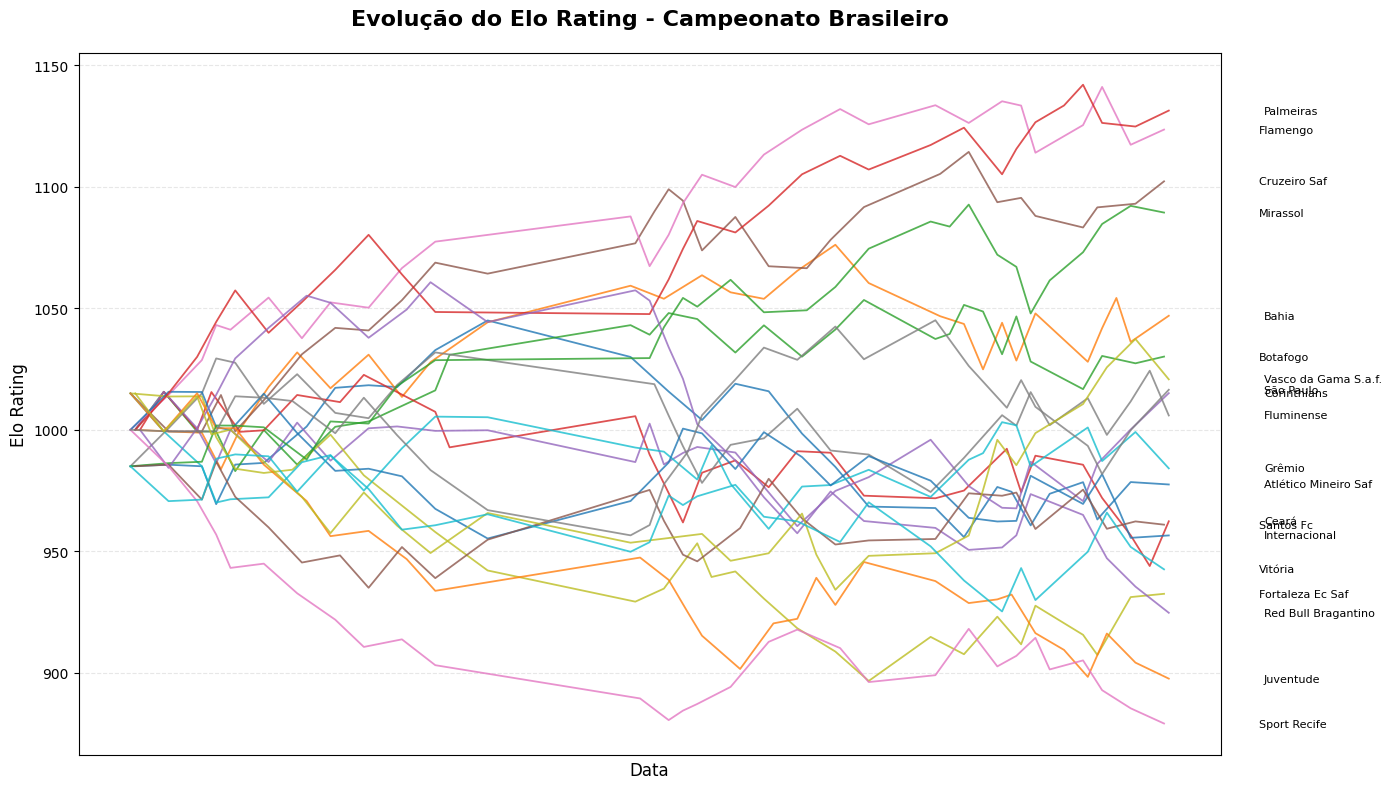

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# === CONFIGURAÇÃO ===
ARQUIVO_ELO = 'elo_2025.csv'

# === LEITURA DOS DADOS ===
df = pd.read_csv(ARQUIVO_ELO)
df['data'] = pd.to_datetime(df['data'], errors='coerce')
df = df.sort_values(by=['data', 'time']).reset_index(drop=True)

# === PLOTAGEM ===
plt.figure(figsize=(14, 8))
ax = plt.gca()

# Determina a posição do último ponto de cada time
ultimos = df.sort_values('data').groupby('time').last().reset_index()

for time in sorted(df['time'].unique()):
    dados = df[df['time'] == time]
    plt.plot(dados['data'], dados['elo'], linewidth=1.3, alpha=0.8)
    
    # Adiciona o nome do time ao final da linha
    ultimo_ponto = dados.iloc[-1]
    ax.text(
        ultimo_ponto['data'] + pd.Timedelta(days=20),  # desloca o nome um pouco à direita
        ultimo_ponto['elo'],
        time,
        fontsize=8,
        color='black',
        va='center'
    )

# === FORMATAÇÃO DO GRÁFICO ===
plt.title('Evolução do Elo Rating - Campeonato Brasileiro', fontsize=16, weight='bold', pad=20)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Elo Rating', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)

# Formatação do eixo X (por ano)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()

# Remove a legenda para evitar poluição
plt.tight_layout()
plt.show()


In [48]:
import pandas as pd
import math

# === CONFIGURAÇÕES ===
ARQUIVO_ELO = 'elo_2025.csv'
THRESHOLD_EMPATE = 5  # quanto mais alto, mais empates são previstos

# === FUNÇÕES ===
def carregar_elos():
    """Carrega o último Elo conhecido de cada time."""
    df = pd.read_csv(ARQUIVO_ELO)
    df = df.sort_values(by=['data']).dropna(subset=['time', 'elo'])
    ultimos = df.groupby('time')['elo'].last().to_dict()
    return ultimos

def probabilidade_vitoria(elo_a, elo_b):
    """Calcula a probabilidade de vitória de A sobre B (modelo Elo clássico)."""
    return 1 / (1 + 10 ** ((elo_b - elo_a) / 400))

def prever_resultado(time_a, time_b, elos):
    """Prediz o resultado mais provável entre dois times."""
    if time_a not in elos or time_b not in elos:
        return f"❌ Um dos times ({time_a}, {time_b}) não tem Elo registrado."

    elo_a, elo_b = elos[time_a], elos[time_b]
    p_a = probabilidade_vitoria(elo_a, elo_b)
    p_b = 1 - p_a

    # Probabilidade empírica de empate (quanto mais próximos, maior chance)
    diff = abs(p_a - 0.5)
    p_empate = max(0, (1 - diff * 10)) * THRESHOLD_EMPATE

    # Normaliza probabilidades
    total = p_a + p_b + p_empate
    p_a, p_b, p_empate = p_a / total, p_b / total, p_empate / total

    # Escolha final
    if max(p_a, p_b, p_empate) == p_empate:
        resultado = "Empate"
    elif p_a > p_b:
        resultado = time_a
    else:
        resultado = time_b

    return {
        "time_A": time_a,
        "Elo_A": round(elo_a, 2),
        "time_B": time_b,
        "Elo_B": round(elo_b, 2),
        "P(A)": round(p_a, 3),
        "P(Empate)": round(p_empate, 3),
        "P(B)": round(p_b, 3),
        "Previsão": resultado
    }



In [45]:
df.time.unique()

array(['Atlético Mineiro Saf', 'Cruzeiro Saf', 'Flamengo', 'Fluminense',
       'Fortaleza Ec Saf', 'Grêmio', 'Internacional', 'Juventude',
       'Mirassol', 'Sport Recife', 'São Paulo', 'Vitória', 'Bahia',
       'Botafogo', 'Corinthians', 'Palmeiras', 'Santos Fc',
       'Vasco da Gama S.a.f.', 'Ceará', 'Red Bull Bragantino'],
      dtype=object)

In [66]:
import pandas as pd

# === CONFIGURAÇÕES ===
ARQUIVO_JOGOS = "jogos_2025_formatados.csv"
ANO = 2025  # ano de interesse

# === LEITURA DOS DADOS ===
df = pd.read_csv(ARQUIVO_JOGOS)
df.columns = [c.strip().lower() for c in df.columns]
df = df[df["ano"] == ANO].copy()

# Normaliza nomes de times
df["mandante"] = df["mandante"].astype(str).str.strip()
df["visitante"] = df["visitante"].astype(str).str.strip()

# === CRIA CHAVE DE CONFRONTO ===
# Cada confronto é definido pelo conjunto (mandante, visitante), ignorando ordem
df["confronto"] = df.apply(lambda row: "_".join(sorted([row["mandante"], row["visitante"]])), axis=1).astype(str)

# === CONTA QUANTOS JOGOS CADA CONFRONTO TEVE ===
contagem = df["confronto"].value_counts().reset_index()
contagem.columns = ["confronto", "ocorrencias"]

# === IDENTIFICA OS CONFRONTOS INCOMPLETOS (MENOS DE 2 JOGOS) ===
faltando = contagem[contagem["ocorrencias"] < 2]

# === MONTA LISTA DE JOGOS FALTANTES ===
faltantes_lista = []

for confronto in faltando["confronto"]:
    time1, time2 = confronto.split("_")
    subset = df[df["confronto"] == confronto]
    mandantes_existentes = set(subset["mandante"])

    # Define quem ainda precisa ser mandante
    if time1 not in mandantes_existentes:
        faltantes_lista.append((time1, time2))
    elif time2 not in mandantes_existentes:
        faltantes_lista.append((time2, time1))
    else:
        # Caso raro: ambos já foram mandantes (erro ou duplicado)
        faltantes_lista.append(("?", "?"))

# === RESULTADO FINAL ===
df_faltantes = pd.DataFrame(faltantes_lista, columns=["Mandante", "Visitante"]).dropna()
df_faltantes = df_faltantes[df_faltantes["Mandante"] != "?"]
df_faltantes = df_faltantes.sort_values(by=["Mandante", "Visitante"]).reset_index(drop=True)

print("\n⚽ JOGOS FALTANTES DO BRASILEIRÃO 2025\n")

# === SALVA RESULTADO ===
df_faltantes



⚽ JOGOS FALTANTES DO BRASILEIRÃO 2025



,Mandante,Visitante
0,Atlético Mineiro Saf,Bahia
1,Atlético Mineiro Saf,Flamengo
2,Atlético Mineiro Saf,Palmeiras
3,Atlético Mineiro Saf,Vasco da Gama S.a.f.
4,Bahia,Fortaleza Ec Saf
...,...,...
64,Vasco da Gama S.a.f.,Mirassol
65,Vitória,Botafogo
66,Vitória,Internacional
67,Vitória,Mirassol


In [69]:
elos = carregar_elos()
resultados = []
for time_a, time_b in zip(df_faltantes.Mandante.to_list(), df_faltantes.Visitante.to_list()):
    previsao = prever_resultado(time_a, time_b, elos)
    print("\n📊 Resultado da previsão:")
    for k, v in previsao.items():
        print(f"{k}: {v}")
    resultados.append([time_a,time_b,v])
    print("\n" + "-"*50 + "\n")



📊 Resultado da previsão:
time_A: Atlético Mineiro Saf
Elo_A: 977.51
time_B: Bahia
Elo_B: 1046.94
P(A): 0.375
P(Empate): 0.065
P(B): 0.56
Previsão: Bahia

--------------------------------------------------


📊 Resultado da previsão:
time_A: Atlético Mineiro Saf
Elo_A: 977.51
time_B: Flamengo
Elo_B: 1123.55
P(A): 0.301
P(Empate): 0.0
P(B): 0.699
Previsão: Flamengo

--------------------------------------------------


📊 Resultado da previsão:
time_A: Atlético Mineiro Saf
Elo_A: 977.51
time_B: Palmeiras
Elo_B: 1131.37
P(A): 0.292
P(Empate): 0.0
P(B): 0.708
Previsão: Palmeiras

--------------------------------------------------


📊 Resultado da previsão:
time_A: Atlético Mineiro Saf
Elo_A: 977.51
time_B: Vasco da Gama S.a.f.
Elo_B: 1020.77
P(A): 0.151
P(Empate): 0.656
P(B): 0.194
Previsão: Empate

--------------------------------------------------


📊 Resultado da previsão:
time_A: Bahia
Elo_A: 1046.94
time_B: Fortaleza Ec Saf
Elo_B: 932.52
P(A): 0.659
P(Empate): 0.0
P(B): 0.341
Previsão: 

In [70]:
import pandas as pd

# === CONFIGURAÇÕES ===
ARQUIVO_JOGOS = "jogos_2025_formatados.csv"
ANO = 2025  # Filtrar apenas jogos de 2025

# === LEITURA DOS DADOS ===
df = pd.read_csv(ARQUIVO_JOGOS)

# Garante nomes de colunas consistentes
df.columns = [c.strip().lower() for c in df.columns]
df = df[df["ano"] == ANO]

# === INICIALIZAÇÃO ===
times = set(df["mandante"]) | set(df["visitante"])
tabela = pd.DataFrame({
    "Time": list(times),
    "P": 0,     # Pontos
    "J": 0,     # Jogos
    "V": 0,     # Vitórias
    "E": 0,     # Empates
    "D": 0,     # Derrotas
    "GP": 0,    # Gols Pró
    "GC": 0,    # Gols Contra
    "SG": 0,    # Saldo
})

tabela.set_index("Time", inplace=True)

# === PROCESSAMENTO DOS JOGOS ===
for _, row in df.iterrows():
    mandante = row["mandante"]
    visitante = row["visitante"]
    gm = int(row["gol_time_mandante"])
    gv = int(row["gol_time_visitante"])

    # Atualiza jogos
    tabela.loc[mandante, "J"] += 1
    tabela.loc[visitante, "J"] += 1

    # Gols
    tabela.loc[mandante, "GP"] += gm
    tabela.loc[mandante, "GC"] += gv
    tabela.loc[visitante, "GP"] += gv
    tabela.loc[visitante, "GC"] += gm

    # Resultado
    if gm > gv:  # vitória mandante
        tabela.loc[mandante, "V"] += 1
        tabela.loc[visitante, "D"] += 1
        tabela.loc[mandante, "P"] += 3
    elif gm < gv:  # vitória visitante
        tabela.loc[visitante, "V"] += 1
        tabela.loc[mandante, "D"] += 1
        tabela.loc[visitante, "P"] += 3
    else:  # empate
        tabela.loc[mandante, "E"] += 1
        tabela.loc[visitante, "E"] += 1
        tabela.loc[mandante, "P"] += 1
        tabela.loc[visitante, "P"] += 1

# === CALCULA SALDO ===
tabela["SG"] = tabela["GP"] - tabela["GC"]

# === ORDENAÇÃO (CRITÉRIOS OFICIAIS) ===
tabela = tabela.sort_values(
    by=["P", "V", "SG", "GP", "GC", "Time"],
    ascending=[False, False, False, False, True, True]
).reset_index()

# === FORMATAÇÃO FINAL ===
tabela["Posição"] = range(1, len(tabela) + 1)
tabela = tabela[
    ["Posição", "Time", "P", "J", "V", "E", "D", "GP", "GC", "SG"]
]

# === RESULTADO ===
print("\n🏆 CLASSIFICAÇÃO DO BRASILEIRÃO 2025\n")
print(tabela.to_string(index=False))

# === OPCIONAL: salva em CSV ===
tabela.to_csv("classificacao_brasileirao_2025.csv", index=False)
print("\n✅ Arquivo salvo: classificacao_brasileirao_2025.csv")



🏆 CLASSIFICAÇÃO DO BRASILEIRÃO 2025

 Posição                 Time  P  J  V  E  D  GP  GC  SG
       1            Palmeiras 65 30 20  5  5  55  26  29
       2             Flamengo 64 30 19  7  4  59  16  43
       3         Cruzeiro Saf 60 31 17  9  5  45  22  23
       4             Mirassol 56 31 15 11  5  52  31  21
       5                Bahia 52 31 15  7  9  42  35   7
       6             Botafogo 48 31 13  9  9  41  28  13
       7           Fluminense 47 31 14  5 12  37  37   0
       8            São Paulo 44 31 12  8 11  35  33   2
       9 Vasco da Gama S.a.f. 42 31 12  6 13  49  43   6
      10          Corinthians 42 31 11  9 11  34  35  -1
      11               Grêmio 39 31 10  9 12  33  40  -7
      12                Ceará 38 31 10  8 13  29  29   0
      13 Atlético Mineiro Saf 37 30  9 10 11  27  32  -5
      14  Red Bull Bragantino 36 31 10  6 15  35  49 -14
      15        Internacional 36 31  9  9 13  35  43  -8
      16            Santos Fc 33 30  8  9 13  31  

In [71]:
import pandas as pd

# === 1️⃣ Lê a tabela atual ===
tabela = pd.read_csv("classificacao_brasileirao_2025.csv")

# === 2️⃣ Lista de previsões ===
previsoes = resultados

# === 3️⃣ Atualiza estatísticas conforme previsões ===
tabela.set_index("Time", inplace=True)

for mandante, visitante, resultado in previsoes:
    if resultado == "Empate":
        gm, gv = 0, 0
        tabela.loc[mandante, "E"] += 1
        tabela.loc[visitante, "E"] += 1
        tabela.loc[mandante, "P"] += 1
        tabela.loc[visitante, "P"] += 1
    elif resultado == mandante:  # vitória do mandante
        gm, gv = 1, 0
        tabela.loc[mandante, "V"] += 1
        tabela.loc[visitante, "D"] += 1
        tabela.loc[mandante, "P"] += 3
    else:  # vitória do visitante
        gm, gv = 0, 1
        tabela.loc[visitante, "V"] += 1
        tabela.loc[mandante, "D"] += 1
        tabela.loc[visitante, "P"] += 3

    # Atualiza jogos e gols
    tabela.loc[mandante, "J"] += 1
    tabela.loc[visitante, "J"] += 1
    tabela.loc[mandante, "GP"] += gm
    tabela.loc[visitante, "GP"] += gv
    tabela.loc[mandante, "GC"] += gv
    tabela.loc[visitante, "GC"] += gm

# === 4️⃣ Recalcula saldo de gols ===
tabela["SG"] = tabela["GP"] - tabela["GC"]

# === 5️⃣ Reordena conforme critérios oficiais ===
tabela = tabela.sort_values(
    by=["P", "V", "SG", "GP", "GC", "Time"],
    ascending=[False, False, False, False, True, True]
).reset_index()

# === 6️⃣ Adiciona posição ===
tabela["Posição"] = range(1, len(tabela) + 1)
tabela = tabela[["Posição", "Time", "P", "J", "V", "E", "D", "GP", "GC", "SG"]]

# === 7️⃣ Resultado final ===
print("\n🏆 CLASSIFICAÇÃO PROJETADA DO BRASILEIRÃO 2025 (com previsões)\n")
print(tabela.to_string(index=False))

# === 8️⃣ (Opcional) salva nova tabela ===
tabela.to_csv("classificacao_brasileirao_2025_projetada.csv", index=False)
print("\n✅ Nova classificação salva: classificacao_brasileirao_2025_projetada.csv")



🏆 CLASSIFICAÇÃO PROJETADA DO BRASILEIRÃO 2025 (com previsões)

 Posição                 Time  P  J  V  E  D  GP  GC  SG
       1             Flamengo 86 38 26  8  4  66  16  50
       2            Palmeiras 81 36 25  6  5  60  26  34
       3         Cruzeiro Saf 81 38 24  9  5  52  22  30
       4             Mirassol 73 38 20 13  5  57  31  26
       5                Bahia 69 38 20  9  9  47  35  12
       6             Botafogo 60 38 16 12 10  44  29  15
       7            São Paulo 56 38 15 11 12  38  34   4
       8          Corinthians 54 38 14 12 12  37  36   1
       9 Vasco da Gama S.a.f. 52 38 14 10 14  51  44   7
      10           Fluminense 50 38 14  8 16  37  41  -4
      11               Grêmio 46 38 11 13 14  34  42  -8
      12 Atlético Mineiro Saf 42 36 10 12 14  28  35  -7
      13                Ceará 41 38 10 11 17  29  33  -4
      14        Internacional 41 38  9 14 15  35  45 -10
      15            Santos Fc 40 36 10 10 16  33  46 -13
      16  Red Bull Braga